In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout, Embedding,  BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

import warnings
warnings.filterwarnings('ignore')


In [2]:
data = pd.read_csv('/content/Amazon-Product-Reviews-Sentiment-Analysis-in-Python-Dataset.csv')

# Printing shape of the dataset
print(data.shape)
# printing columns and rows information
print(data.info())


(25000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     24999 non-null  object
 1   Sentiment  25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB
None


In [3]:
# looking for NULL values
print("Null Values:\n", data.isna().sum())

# dropping null values
data = data.dropna()

# again checking for NULL values
print("Null Values after dropping:\n", data.isna().sum())


Null Values:
 Review       1
Sentiment    0
dtype: int64
Null Values after dropping:
 Review       0
Sentiment    0
dtype: int64


In [4]:
# count of unique values in Sentiment column
data['Sentiment'].value_counts()

,count
Sentiment,
1,5000
2,5000
3,5000
4,5000
5,4999


In [5]:
# downloading stopwords from nltk library
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# downloading punkt sentence tokenizer models
nltk.download('punkt')

# Review text Cleaning
def clean_reviews(text):

    # removing html brackets and other square brackets from the string using regex
    regex = re.compile('<.*?>') # r'<.*?>'
    text = re.sub(regex, '', text)

    # removing special characters like @, #, $, etc
    pattern = re.compile('[^a-zA-z0-9\s]')
    text = re.sub(pattern,'',text)

    # removing numbers
    pattern = re.compile('\d+')
    text = re.sub(pattern,'',text)

    # converting text to lower case
    text = text.lower()

    # Tokenization of words
    text = word_tokenize(text)

    # Stop words removal
    text = [word for word in text if not word in stop_words]

    return text

# using the clean_reviews function on the dataset
data['Review'] = data['Review'].apply(clean_reviews)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
tokenizer = Tokenizer()

# converting all the reviews to list to pass it as a parameter to fit_on_texts
reviews_to_list = data['Review'].tolist()
tokenizer.fit_on_texts(reviews_to_list)

# Generating text sequences
text_sequences = tokenizer.texts_to_sequences(reviews_to_list)

# setting maximum words we want in an example
max_words = 500

# Padding sequences
# - Before converting to a NumPy array, pad the sequences to ensure they all have the same length.
padded_sequences = pad_sequences(text_sequences, maxlen=max_words) # Use the same max_words value

text_sequences = np.array(padded_sequences)

# one hot encoding
data = pd.get_dummies(data, columns = ['Sentiment'])


# Generatin our X (input) to the model
# using pad_sequences and y (output)
X = pad_sequences(text_sequences, maxlen = max_words)
y = data[['Sentiment_1', 'Sentiment_2', 'Sentiment_3', 'Sentiment_4',
    'Sentiment_5']]
print(X.shape, y.shape)


(24999, 500) (24999, 5)


In [7]:
# Train Test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(19999, 500) (5000, 500) (19999, 5) (5000, 5)


In [9]:
# Creating a RNN model
rnn = Sequential(name="Simple_RNN")
rnn.add(Embedding(len(tokenizer.word_index)+1,
                        max_words,
                        input_length=max_words))

rnn.add(SimpleRNN(128,activation='relu',return_sequences=True))

rnn.add(SimpleRNN(64,activation='relu',return_sequences=False))

rnn.add(Dense(5, activation='softmax'))

# printing model summary
print(rnn.summary())

Model: "Simple_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [10]:
# Compiling model
rnn.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)

# Training the model
history = rnn.fit(X_train, y_train,
                        batch_size=64,
                        epochs=2,
                        verbose=1,
                          validation_data = (X_test, y_test))

# Printing model score on test data
print("Simple_RNN Score---> ", rnn.evaluate(X_test, y_test, verbose=1))

Epoch 1/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 452s 1s/step - accuracy: 0.2993 - loss: 1.5085 - val_accuracy: 0.4464 - val_loss: 1.2442
Epoch 2/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 459s 1s/step - accuracy: 0.5510 - loss: 1.0688 - val_accuracy: 0.4532 - val_loss: 1.2610
157/157 ━━━━━━━━━━━━━━━━━━━━ 30s 193ms/step - accuracy: 0.4532 - loss: 1.2637
Simple_RNN Score--->  [1.2609885931015015, 0.45320001244544983]


LSTM ( Long Short Term Memory)

In [11]:
model = Sequential(name="LSTM_Model")
model.add(Embedding(len(tokenizer.word_index)+1,
                    max_words,
                    input_length=max_words))

# adding a LSTM layer
model.add(LSTM(150, return_sequences=False))
BatchNormalization()
model.add(Dropout(0.5))

#adding a dense layer with activation function of relu
model.add(Dense(50, activation='relu'))
BatchNormalization()
model.add(Dropout(0.5))

# adding the final output activation with activation function of softmax
model.add(Dense(5, activation='softmax'))

# printing model summary
print(model.summary())

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [12]:
# Compiling the model
model.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)

# Training the GRU model
history = model.fit(X_train, y_train,
                         batch_size=64,
                         epochs=3,
                         verbose=1,
                       validation_data=(X_test, y_test))

# Printing model score on test data
print("LSTM model Score---> ", model.evaluate(X_test, y_test, verbose=1))

Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 901s 3s/step - accuracy: 0.3144 - loss: 1.4846 - val_accuracy: 0.4516 - val_loss: 1.2380
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 921s 3s/step - accuracy: 0.5184 - loss: 1.1027 - val_accuracy: 0.4638 - val_loss: 1.2239
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 892s 3s/step - accuracy: 0.6276 - loss: 0.9056 - val_accuracy: 0.4408 - val_loss: 1.3571
157/157 ━━━━━━━━━━━━━━━━━━━━ 67s 426ms/step - accuracy: 0.4365 - loss: 1.3469
LSTM model Score--->  [1.3571429252624512, 0.4408000111579895]


Text(0, 0.5, 'Accuracy')

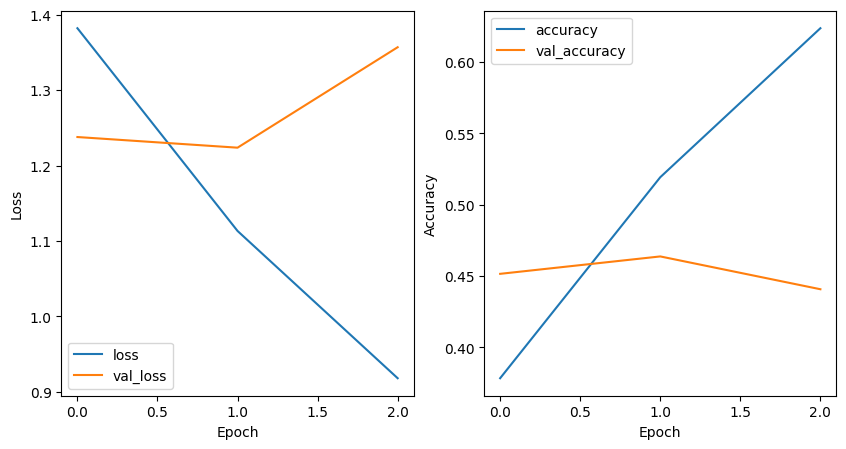

In [13]:
# Plotting the history
metrics = history.history
plt.figure(figsize=(10, 5))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'],
         metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


157/157 ━━━━━━━━━━━━━━━━━━━━ 68s 429ms/step


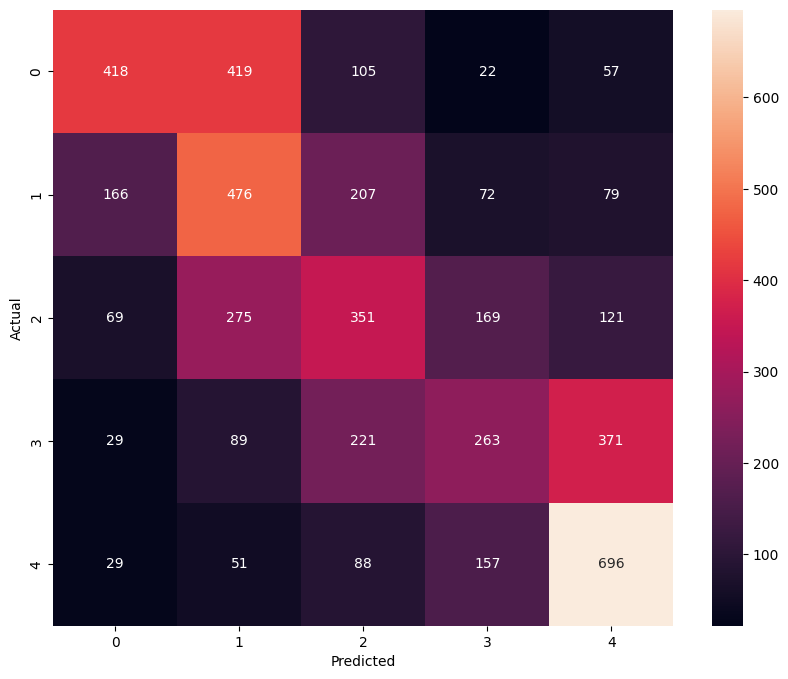

In [14]:
# converting y_test tht was one hot encoded to one column fo rconfusion matrix
y_true = np.argmax(y_test.values, axis=1)
y_true.shape

# Confusion matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = tf.math.confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [15]:
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.59      0.41      0.48      1021
           1       0.36      0.48      0.41      1000
           2       0.36      0.36      0.36       985
           3       0.39      0.27      0.32       973
           4       0.53      0.68      0.59      1021

    accuracy                           0.44      5000
   macro avg       0.44      0.44      0.43      5000
weighted avg       0.45      0.44      0.43      5000



In [16]:
def predict_review_rating(text):
  text_sequences_test = np.array(tokenizer.texts_to_sequences([text]))
  testing = pad_sequences(text_sequences_test, maxlen = max_words)
  y_pred_test = np.argmax(model.predict(testing), axis=1)
  return y_pred_test[0]+1

# Testing
rating1 = predict_review_rating('Worst product')
print("The rating according to the review is: ", rating1)

rating2 = predict_review_rating('Awesome product,  I will recommend this to other users.')
print("The rating according to the review is: ", rating2)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
The rating according to the review is:  1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
The rating according to the review is:  5
